<a href="https://colab.research.google.com/github/MANOJ9590/Research_Lab-SS2022/blob/main/LSTM_for_Forcecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime, timedelta
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/MANOJ9590/Research_Lab-SS2022/main/Daily_data.csv",delimiter = ";",index_col=False)

In [4]:
data.drop(['Unnamed: 0'],inplace=True, axis=1)
data.dropna()
data=data.set_index('Date')
data

,Confirmed Cases,Deaths,Recoveries
Date,,,
25/02/20,16,0,14.0
26/02/20,21,0,15.0
27/02/20,26,0,16.0
28/02/20,53,0,16.0
29/02/20,66,0,16.0
...,...,...,...
19/06/22,27211896,140176,NaN
20/06/22,27334993,140358,26197700.0
21/06/22,27454225,140462,26253400.0


In [5]:
dates = np.array(data.index)
dates = [datetime.strptime(date, '%d/%m/%y').date() for date in dates]
dates = [x.strftime('%Y-%m-%d') for x in dates]

confirmed_pk = np.array(data[['Confirmed Cases']])
deaths_pk = np.array(data[['Deaths']])
recovered_pk = np.array(data[['Recoveries']])

In [6]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)

In [7]:
df = pd.DataFrame(np.append(np.array(dates).reshape(-1,1), conf_death_recov, axis = 1), columns = ['Date', 'Confirmed Cases', 'Deaths', 'Recoveries']).dropna()


df = df[df.Recoveries != 'nan']
df

,Date,Confirmed Cases,Deaths,Recoveries
0,2020-02-25,16.0,0.0,14.0
1,2020-02-26,21.0,0.0,15.0
2,2020-02-27,26.0,0.0,16.0
3,2020-02-28,53.0,0.0,16.0
4,2020-02-29,66.0,0.0,16.0
...,...,...,...,...
843,2022-06-17,27204953.0,140176.0,26132100.0
846,2022-06-20,27334993.0,140358.0,26197700.0
847,2022-06-21,27454225.0,140462.0,26253400.0
848,2022-06-22,27573585.0,140560.0,26306700.0


In [8]:
confirmed_pk = np.array(df[['Confirmed Cases']])
deaths_pk = np.array(df[['Deaths']])
recovered_pk = np.array(df[['Recoveries']])
dates = df['Date'].tolist()

In [9]:
conf_death_recov = np.concatenate((confirmed_pk.reshape(-1,1), deaths_pk.reshape(-1,1), recovered_pk.reshape(-1,1)),  axis=1)


In [10]:
confirmed_df = df.iloc[:, [0,1]]
confirmed_df = confirmed_df.set_index('Date')
confirmed_df= confirmed_df.astype({'Confirmed Cases': float},errors = 'raise')


print(confirmed_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 2020-02-25 to 2022-06-23
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Confirmed Cases  749 non-null    float64
dtypes: float64(1)
memory usage: 11.7+ KB
None


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
physical_devices = tf.config.experimental.list_physical_devices('GPU')

In [12]:
scaler_confirm = MinMaxScaler()
scaler_confirm = scaler_confirm.fit(confirmed_df)
train_confirm = scaler_confirm.fit_transform(confirmed_df)
train_confirm = pd.DataFrame(train_confirm)

In [13]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [14]:
time_steps = 1
X_train_confirm, y_train_confirm = create_dataset(train_confirm, train_confirm, time_steps)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

confirm_model = keras.Sequential()
confirm_model.add(keras.layers.LSTM(units=128,input_shape=(X_train_confirm.shape[1], X_train_confirm.shape[2]),return_sequences = True))
confirm_model.add(keras.layers.LSTM(units=128,return_sequences = True))
confirm_model.add(keras.layers.LSTM(units=128,return_sequences = True))
confirm_model.add(keras.layers.LSTM(units=128))
confirm_model.add(keras.layers.Dropout(rate=0.2))
confirm_model.add(keras.layers.Dense(units=1))
confirm_model.compile(loss='mean_squared_error', optimizer='adam') 
reset_states = ResetStatesCallback()
confirm_model.fit(X_train_confirm, y_train_confirm,epochs=1000,batch_size=16,shuffle=False,callbacks = [reset_states],verbose = 1)

In [16]:
DAYS_TO_PREDICT = 7

In [17]:
confirm_test_seq  = y_train_confirm[-1:]
confirm_preds = []
for _ in range(DAYS_TO_PREDICT):
    y2_confirm = confirm_test_seq.reshape((len(confirm_test_seq ), time_steps, 1))
    confirm_pred = confirm_model.predict(y2_confirm)
    confirm_preds.append(confirm_pred)
    confirm_new_seq = confirm_test_seq.flatten()
    confirm_new_seq = np.append(confirm_new_seq,[confirm_pred])
    confirm_new_seq = confirm_new_seq[-1:]
    confirm_test_seq = confirm_new_seq.reshape((len(confirm_new_seq), time_steps, 1))
    y2_confirm = confirm_test_seq
    
confirm_preds = (np.array(confirm_preds).flatten()).reshape(-1,1)
confirm_preds = scaler_confirm.inverse_transform(confirm_preds)

predicted_confirmed_index = pd.date_range(start=confirmed_df.index[-1],periods=DAYS_TO_PREDICT + 1,closed='right').strftime('%Y-%m-%d')
predicted_confirmed_cases = pd.DataFrame()
predicted_confirmed_cases['Dates'] = predicted_confirmed_index
predicted_confirmed_cases['Confirmed Cases Predictions'] = confirm_preds
predicted_confirmed_cases.set_index('Dates', inplace = True)

In [18]:
predicted_confirmed_cases

,Confirmed Cases Predictions
Dates,
2022-06-24,25813718.0
2022-06-25,25161994.0
2022-06-26,24757866.0
2022-06-27,24469522.0
2022-06-28,24247984.0
2022-06-29,24069554.0
2022-06-30,23920982.0


In [19]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=predicted_confirmed_cases.index, 
                         y=predicted_confirmed_cases['Confirmed Cases Predictions'],
                         mode='lines+markers',
                         name='confirm',
                         line=dict(color='red', width=2)))

In [20]:
death_df = df.iloc[:, [0,2]]
death_df = death_df.set_index('Date')
death_df= death_df.astype({'Deaths': float},errors = 'raise')


print(death_df.info())
death_df

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 2020-02-25 to 2022-06-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Deaths  749 non-null    float64
dtypes: float64(1)
memory usage: 11.7+ KB
None


,Deaths
Date,
2020-02-25,0.0
2020-02-26,0.0
2020-02-27,0.0
2020-02-28,0.0
2020-02-29,0.0
...,...
2022-06-17,140176.0
2022-06-20,140358.0
2022-06-21,140462.0


In [21]:
scaler_death = MinMaxScaler()
scaler_death = scaler_death.fit(death_df)
train_death = scaler_death.transform(death_df)
train_death = pd.DataFrame(train_death)

In [22]:
X_train_death, y_train_death = create_dataset(train_death, train_death, time_steps)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

death_model = keras.Sequential()
death_model.add(keras.layers.LSTM(units=128,input_shape=(X_train_death.shape[1], X_train_death.shape[2]),return_sequences = True))
death_model.add(keras.layers.LSTM(units=128,return_sequences = True))
death_model.add(keras.layers.LSTM(units=128,return_sequences = True))
death_model.add(keras.layers.LSTM(units=128))
death_model.add(keras.layers.Dropout(rate=0.2))
death_model.add(keras.layers.Dense(units=1))
death_model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"]) 
reset_states = ResetStatesCallback()
death_model.fit(X_train_death, y_train_death,epochs=500,batch_size=16,shuffle=False,callbacks = [reset_states],verbose=1)

In [25]:
death_test_seq  = y_train_death[-1:]
death_preds = []
for i in range(DAYS_TO_PREDICT):
    y2_death = death_test_seq.reshape((len(death_test_seq), time_steps, 1))
    death_pred = death_model.predict(y2_death)
    death_preds.append(death_pred)
    death_new_seq = death_test_seq.flatten()
    death_new_seq = np.append(death_new_seq,[death_pred])
    death_new_seq = death_new_seq[-1:]
    death_test_seq = death_new_seq.reshape((len(death_new_seq), time_steps, 1))
    y2_death = death_test_seq
    
death_preds = (np.array(death_preds).flatten()).reshape(-1,1)
death_preds = scaler_death.inverse_transform(death_preds)

predict_death_index = pd.date_range(start=death_df.index[-1],periods=DAYS_TO_PREDICT + 1,closed='right').strftime('%Y-%m-%d')
predict_death_cases = pd.DataFrame()
predict_death_cases['Dates'] = predict_death_index
predict_death_cases['Death Cases Predictions'] = death_preds
predict_death_cases.set_index('Dates', inplace = True)

In [26]:
predict_death_cases

,Death Cases Predictions
Dates,
2022-06-24,142736.796875
2022-06-25,144510.281250
2022-06-26,146002.078125
2022-06-27,147245.875000
2022-06-28,148275.062500
2022-06-29,149121.187500
2022-06-30,149813.187500


In [27]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=predict_death_cases.index, 
                         y=predict_death_cases['Death Cases Predictions'],
                         mode='lines+markers',
                         name='death',
                         line=dict(color='blue', width=2)))

In [28]:
recovered_df = df.iloc[:, [0,3]]
recovered_df = recovered_df.set_index('Date')
recovered_df= recovered_df.astype({'Recoveries': float},errors = 'raise')


print(recovered_df.info())
recovered_df

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 2020-02-25 to 2022-06-23
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recoveries  749 non-null    float64
dtypes: float64(1)
memory usage: 11.7+ KB
None


,Recoveries
Date,
2020-02-25,14.0
2020-02-26,15.0
2020-02-27,16.0
2020-02-28,16.0
2020-02-29,16.0
...,...
2022-06-17,26132100.0
2022-06-20,26197700.0
2022-06-21,26253400.0


In [29]:
scaler_recovered = MinMaxScaler()
scaler_recovered = scaler_recovered.fit(recovered_df)
train_recovered = scaler_recovered.fit_transform(recovered_df)
train_recovered = pd.DataFrame(train_recovered)

In [30]:
X_train_recovered, y_train_recovered = create_dataset(train_recovered, train_recovered, time_steps)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

recovered_model = keras.Sequential()
recovered_model.add(keras.layers.LSTM(units=128,input_shape=(X_train_recovered.shape[1], X_train_recovered.shape[2]),return_sequences = True))
recovered_model.add(keras.layers.LSTM(units=128,return_sequences = True))
recovered_model.add(keras.layers.LSTM(units=128,return_sequences = True))
recovered_model.add(keras.layers.LSTM(units=128))
recovered_model.add(keras.layers.Dropout(rate=0.2))
recovered_model.add(keras.layers.Dense(units=1))
recovered_model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"]) 
reset_states = ResetStatesCallback()
recovered_model.fit(X_train_recovered, y_train_recovered,epochs=50,batch_size=16,shuffle=False,callbacks = [reset_states],verbose=1)

In [33]:
recovered_test_seq  = y_train_recovered[-1:]
recovered_preds = []
for i in range(DAYS_TO_PREDICT):
    y2_recovered = recovered_test_seq.reshape((len(recovered_test_seq), time_steps, 1))
    recovered_pred = recovered_model.predict(y2_recovered)
    recovered_preds.append(recovered_pred)
    recovered_new_seq = recovered_test_seq.flatten()
    recovered_new_seq = np.append(recovered_new_seq,[recovered_pred])
    recovered_new_seq = recovered_new_seq[-1:]
    recovered_test_seq = recovered_new_seq.reshape((len(recovered_new_seq), time_steps, 1))
    y2_recovered = recovered_test_seq
    
recovered_preds = (np.array(recovered_preds).flatten()).reshape(-1,1)
recovered_preds = scaler_recovered.inverse_transform(recovered_preds)

predict_recovered_index = pd.date_range(start=recovered_df.index[-1],periods=DAYS_TO_PREDICT + 1,closed='right').strftime('%Y-%m-%d')

predict_recovered_cases = pd.DataFrame()
predict_recovered_cases['Dates'] = predict_recovered_index
predict_recovered_cases['Recovered Cases Predictions'] = recovered_preds
predict_recovered_cases.set_index('Dates', inplace = True)

In [34]:
predict_recovered_cases

,Recovered Cases Predictions
Dates,
2022-06-24,22457926.0
2022-06-25,19829926.0
2022-06-26,17927166.0
2022-06-27,16496205.0
2022-06-28,15395090.0
2022-06-29,14535413.0
2022-06-30,13857859.0


In [35]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=predict_recovered_cases.index, 
                         y=predict_recovered_cases['Recovered Cases Predictions'],
                         mode='lines+markers',
                         name='recovered',
                         line=dict(color='green', width=2)))

In [36]:
predection= pd.concat([predicted_confirmed_cases, predict_death_cases, predict_recovered_cases], axis=1)

predection

,Confirmed Cases Predictions,Death Cases Predictions,Recovered Cases Predictions
Dates,,,
2022-06-24,25813718.0,142736.796875,22457926.0
2022-06-25,25161994.0,144510.281250,19829926.0
2022-06-26,24757866.0,146002.078125,17927166.0
2022-06-27,24469522.0,147245.875000,16496205.0
2022-06-28,24247984.0,148275.062500,15395090.0
2022-06-29,24069554.0,149121.187500,14535413.0
2022-06-30,23920982.0,149813.187500,13857859.0


In [37]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=confirmed_df.index, 
                         y=confirmed_df['Confirmed Cases'],
                         mode='lines+markers',
                         name='confirm',
                         line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=death_df.index, 
                         y=death_df['Deaths'],
                         mode='lines+markers',
                         name='death',
                         line=dict(color='green', width=2)))

fig.add_trace(go.Scatter(x=recovered_df.index, 
                         y=recovered_df['Recoveries'],
                         mode='lines+markers',
                         name='recovered',
                         line=dict(color='blue', width=2)))

In [38]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')

fig.add_trace(go.Scatter(x=death_df.index, 
                         y=death_df['Deaths'],
                         mode='lines+markers',
                         name='death',
                         line=dict(color='green', width=2)))

In [39]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=predicted_confirmed_cases.index, 
                         y=predicted_confirmed_cases['Confirmed Cases Predictions'],
                         mode='lines+markers',
                         name='Confirmed Cases Predictions',
                         line=dict(color='yellow', width=2)))

fig.add_trace(go.Scatter(x=predict_death_cases.index, 
                         y=predict_death_cases['Death Cases Predictions'],
                         mode='lines+markers',
                         name='Death Cases Predictions',
                         line=dict(color='turquoise', width=2)))

fig.add_trace(go.Scatter(x=predict_recovered_cases.index, 
                         y=predict_recovered_cases['Recovered Cases Predictions'],
                         mode='lines+markers',
                         name='Recovered Cases Predictions',
                         line=dict(color='white', width=2)))

In [47]:
fig = go.Figure()
fig.update_layout(template='plotly_dark')
fig.update_xaxes(tickangle=90, showticklabels = True, type = 'category')
fig.add_trace(go.Scatter(x=confirmed_df.index, 
                         y=confirmed_df['Confirmed Cases'],
                         mode='lines+markers',
                         name='confirm',
                         line=dict(color='red', width=2)))

fig.add_trace(go.Scatter(x=death_df.index, 
                         y=death_df['Deaths'],
                         mode='lines+markers',
                         name='death',
                         line=dict(color='green', width=2)))

fig.add_trace(go.Scatter(x=recovered_df.index, 
                         y=recovered_df['Recoveries'],
                         mode='lines+markers',
                         name='recovered',
                         line=dict(color='blue', width=2)))

fig.add_trace(go.Scatter(x=predicted_confirmed_cases.index, 
                         y=predicted_confirmed_cases['Confirmed Cases Predictions'],
                         mode='lines+markers',
                         name='Confirmed Cases Predictions',
                         line=dict(color='yellow', width=2)))

fig.add_trace(go.Scatter(x=predict_death_cases.index, 
                         y=predict_death_cases['Death Cases Predictions'],
                         mode='lines+markers',
                         name='Death Cases Predictions',
                         line=dict(color='turquoise', width=2)))

fig.add_trace(go.Scatter(x=predict_recovered_cases.index, 
                         y=predict_recovered_cases['Recovered Cases Predictions'],
                         mode='lines+markers',
                         name='Recovered Cases Predictions',
                         line=dict(color='white', width=2)))

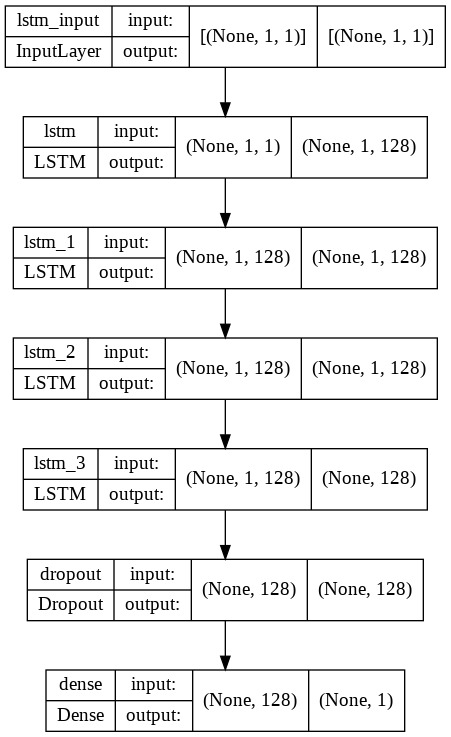

In [43]:
keras.utils.plot_model(recovered_model, show_shapes=True)


In [44]:
recovered_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trai